## Встановлення пакетів

In [8]:
%pip install numpy==1.26.4 tensorflow torch matplotlib kagglehub

Note: you may need to restart the kernel to use updated packages.


## Імпорт пакетів

In [9]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, ConcatDataset
from collections import Counter
import matplotlib.pyplot as plt
import kagglehub

## Підготовка датасету

In [10]:
path = 'Formula One Cars'

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augmentation_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=[-30, 30])
    ], p=0.7),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = datasets.ImageFolder(root=path, transform=transform)

train_val_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_val_size
train_val_dataset, test_dataset = random_split(full_dataset, [train_val_size, test_size])

train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

augmented_full_dataset = datasets.ImageFolder(root=path, transform=augmentation_transform)
train_dataset = ConcatDataset([train_dataset, augmented_full_dataset])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 2883
Val samples: 135
Test samples: 336


## Візуалізація зображень з датасету

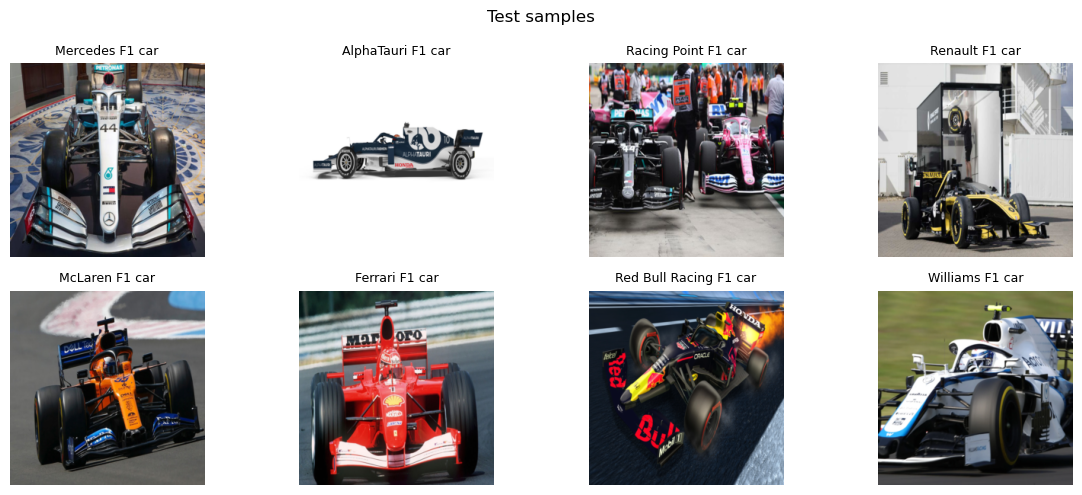

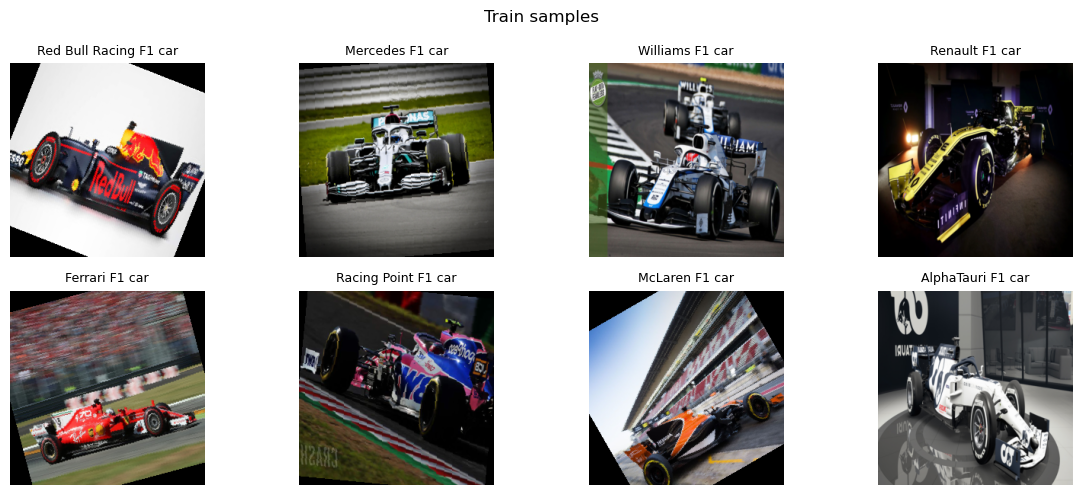

In [11]:
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5
    return tensor

def plot_image(img, title, index, total_rows, total_cols):
    plt.subplot(total_rows, total_cols, index)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title, fontsize=9)
    plt.axis('off')
    
def collect_class_samples(loader, class_names, samples_per_class):
    seen = {cls: 0 for cls in class_names}
    collected = []
    for images, labels in loader:
        for img, label in zip(images, labels):
            class_idx = label.item()
            class_name = class_names[class_idx]
            if seen[class_name] < samples_per_class:
                collected.append((img, class_name))
                seen[class_name] += 1
            if all(count >= samples_per_class for count in seen.values()):
                return collected
    return collected

def show_samples_from_loader(loader, class_names, samples_per_class=2, title = None):
    samples = collect_class_samples(loader, class_names, samples_per_class)
    rows = 2
    cols = (len(samples) + 1) // 2

    plt.figure(figsize=(cols * 3, rows * 2.5))
    
    if title:
        plt.suptitle(title)
    
    for i, (img, title) in enumerate(samples, 1):
        img = denormalize(img).numpy()
        plot_image(img, title, i, rows, cols)
    plt.tight_layout()
    
    plt.show()
    

show_samples_from_loader(test_loader, full_dataset.classes, 1, "Test samples")
show_samples_from_loader(train_loader, full_dataset.classes, 1, "Train samples")

## Кількість зображень на клас

Було проведено ручне очищення датасету: видалено нерелевантні зображення та зображення, які були не відповідали своїм класам.
У результаті датасет зменшився більш ніж на чверть

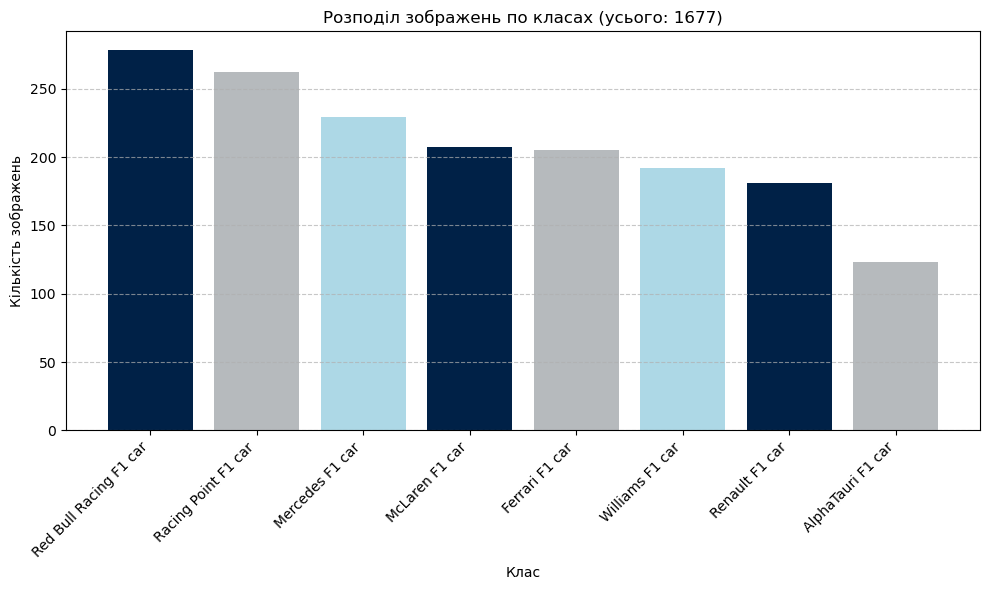

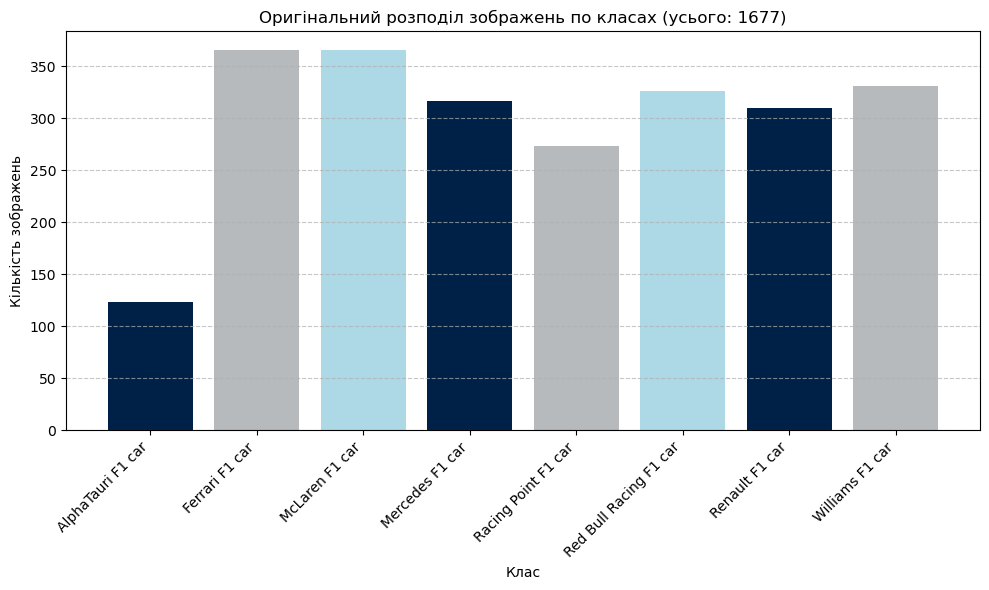

In [15]:
label_indices = full_dataset.targets

label_counts = Counter(label_indices)

idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

sorted_items = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
class_names = [idx_to_class[idx] for idx, _ in sorted_items]
image_counts = [count for _, count in sorted_items]
total_images = sum(image_counts)

colors = [
    "#002147",
    "#B6BABD",
    "#ADD8E6"
]

plt.figure(figsize=(10, 6))
plt.bar(class_names, image_counts, color=colors)
plt.xlabel("Клас")
plt.ylabel("Кількість зображень")
plt.title(f"Розподіл зображень по класах (усього: {total_images})")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# оригінальний датасет
old_dataset_path = "Formula One Cars - original"
original_dataset = datasets.ImageFolder(old_dataset_path)

original_label_indices = original_dataset.targets
original_label_counts = Counter(original_label_indices)
idx_to_class = {v: k for k, v in original_dataset.class_to_idx.items()}

class_names = [k for k, _ in original_dataset.class_to_idx.items()]
original_image_counts = [original_label_counts[original_dataset.class_to_idx[class_name]] for class_name in class_names]
original_total_images = sum(image_counts)

plt.figure(figsize=(10, 6))
plt.bar(class_names, original_image_counts, color=colors)
plt.xlabel("Клас")
plt.ylabel("Кількість зображень")
plt.title(f"Оригінальний розподіл зображень по класах (усього: {original_total_images})")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()